# Individual Assignment

### Imports and settings

In [2]:
import os
os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import pointbiserialr

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, make_scorer, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

pd.set_option("future.no_silent_downcasting", True)


### Load data

In [3]:
heart_disease_data = pd.read_csv("heart-disease.csv")
heart_disease_data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


# EDA

In [4]:
# Convert famhist to 0 (absent) and 1 (present) and make sure it is type int for future operations
heart_disease_data["famhist"] = heart_disease_data["famhist"].replace({"Absent": 0, "Present": 1}).astype(int)

# Check the shape of the dataset
print(f"Dataset shape: {heart_disease_data.shape}")

# Check for missing values
missing_values = heart_disease_data.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

Dataset shape: (462, 10)

Missing values per column:
sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64


In [5]:
# List of numerical features
numerical_features = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']

# Distribution statistics table
distribution_stats = pd.DataFrame({
    'Mean': heart_disease_data[numerical_features].mean(),
    'Median': heart_disease_data[numerical_features].median(),
    'Std Dev': heart_disease_data[numerical_features].std(),
    'Skewness': heart_disease_data[numerical_features].skew(),
    'Kurtosis': heart_disease_data[numerical_features].kurtosis(),
    'Min': heart_disease_data[numerical_features].min(),
    'Max': heart_disease_data[numerical_features].max()
})

print("Distribution Statistics:")
print(distribution_stats)


Distribution Statistics:
                 Mean   Median    Std Dev  Skewness  Kurtosis     Min     Max
sbp        138.326840  134.000  20.496317  1.180591  1.781647  101.00  218.00
tobacco      3.635649    2.000   4.593024  2.079210  5.968108    0.00   31.20
ldl          4.740325    4.340   2.070909  1.313104  2.876553    0.98   15.33
adiposity   25.406732   26.115   7.780699 -0.214646 -0.698439    6.74   42.49
typea       53.103896   53.000   9.817534 -0.346438  0.470402   13.00   78.00
obesity     26.044113   25.805   4.213680  0.905219  2.255972   14.70   46.58
alcohol     17.044394    7.510  24.481059  2.312699  6.421110    0.00  147.19
age         42.816017   45.000  14.608956 -0.381734 -1.016229   15.00   64.00


### Outlier Detection


Outlier Summary:
     Feature  IQR Outliers Count  Z-Score Outliers Count
0        sbp                  15                       9
1    tobacco                  19                      10
2        ldl                  14                       8
3  adiposity                   0                       0
4      typea                   4                       2
5    obesity                   9                       5
6    alcohol                  33                      10
7        age                   0                       0


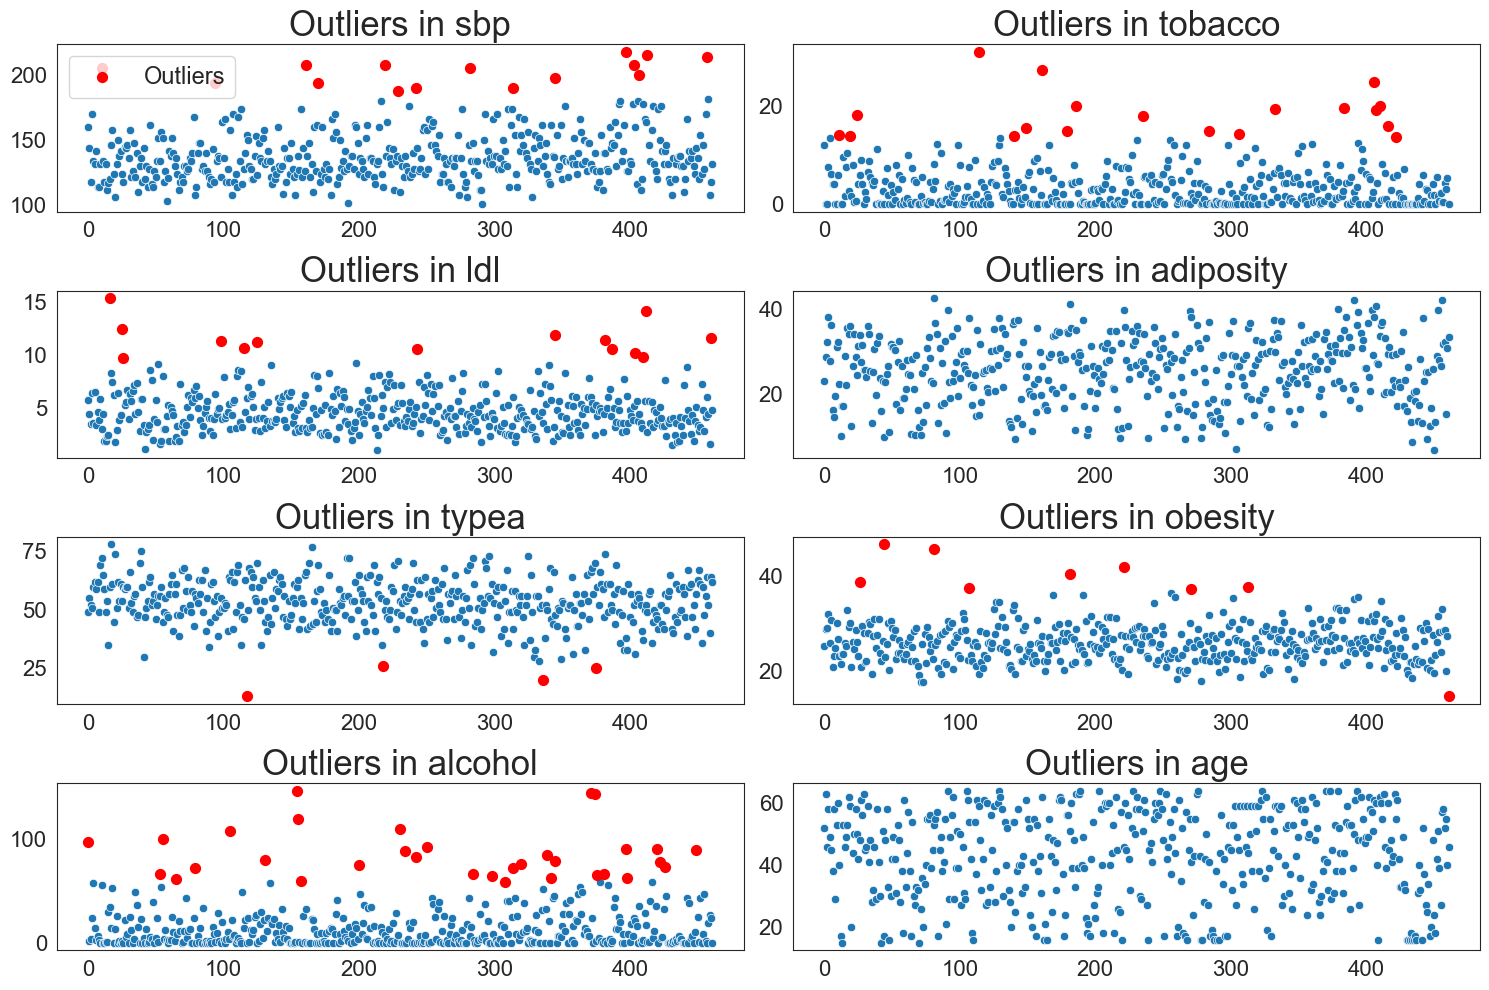

In [22]:
# Outlier Detection

# Function to detect outliers using IQR method
def detect_outliers_iqr(df, columns):
    outlier_indices = {}
    
    for col in columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        # Calculate IQR (Interquartile Range)
        IQR = Q3 - Q1
        
        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Find outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
        outlier_indices[col] = outliers
        
    return outlier_indices

# Function to detect outliers using Z-score method
def detect_outliers_zscore(df, columns, threshold=3):
    outlier_indices = {}
    
    for col in columns:
        # Calculate z-scores
        z_scores = np.abs(stats.zscore(df[col]))
        
        # Find outliers
        outliers = df[z_scores > threshold].index.tolist()
        outlier_indices[col] = outliers
        
    return outlier_indices

# Detect outliers using both methods
iqr_outliers = detect_outliers_iqr(heart_disease_data, numerical_features)
zscore_outliers = detect_outliers_zscore(heart_disease_data, numerical_features)

# Create a summary of outliers
outlier_summary = pd.DataFrame({
    'Feature': numerical_features,
    'IQR Outliers Count': [len(iqr_outliers[col]) for col in numerical_features],
    'Z-Score Outliers Count': [len(zscore_outliers[col]) for col in numerical_features]
})

print("\nOutlier Summary:")
print(outlier_summary)

# Create a dataset without the outliers
outlier_indices = set()
for col in numerical_features:
    outlier_indices.update(iqr_outliers[col])
    outlier_indices.update(zscore_outliers[col])

# Remove outliers from the dataset
heart_disease_data_no_outliers = heart_disease_data.drop(index=outlier_indices)

# Visualize outliers with scatter plots for a few selected features
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_features[:8]):  # Just show first 4 features
    sns.scatterplot(x=heart_disease_data.index, y=heart_disease_data[col], ax=axes[i])
    
    # Highlight IQR outliers
    outlier_idx = iqr_outliers[col]
    if outlier_idx:
        axes[i].scatter(outlier_idx, heart_disease_data.loc[outlier_idx, col], 
                        color='red', s=50, label='Outliers')
    
    axes[i].set_title(f'Outliers in {col}', fontsize=25)
    axes[i].set_xlabel('Index', visible=False)
    axes[i].set_ylabel(col, visible=False)
    
    # Set fontsize for ticks
    axes[i].tick_params(axis='x', labelsize=16)
    axes[i].tick_params(axis='y', labelsize=16)
    
    if i == 0:  # Only add legend to the first plot
        axes[i].legend(fontsize=17)  # Changed fontsize of the legend

plt.tight_layout()
plt.savefig("plots/outliers.png", dpi=300)
plt.show()


### Class Balance

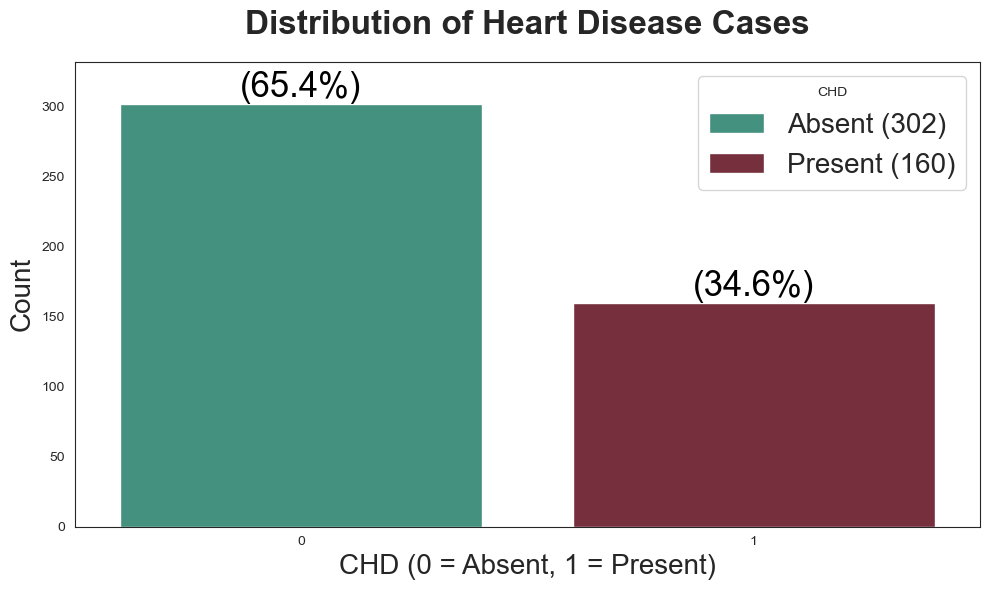

In [33]:
# Set a clean, minimalist style for better visualization
sns.set_style("white")

# Define custom colors for better differentiation between classes
# Green for absence (0) and burgundy for presence (1) of heart disease
custom_palette = {0: "#369E84", 1: "#822335"}

# Create a figure with appropriate dimensions for clear visualization
plt.figure(figsize=(10, 6))

# Generate a count plot showing the distribution of heart disease cases
ax = sns.countplot(x='chd', data=heart_disease_data, palette=custom_palette, hue="chd")

# Add descriptive title and axis labels with increased font size for readability
ax.set_title('Distribution of Heart Disease Cases', fontsize=24, fontweight='bold', pad=20)
ax.set_xlabel('CHD (0 = Absent, 1 = Present)', fontsize=20)
ax.set_ylabel('Count', fontsize=20)

# Remove grid lines for a cleaner appearance
ax.grid(False)

# Add margin to the top of the plot to prevent crowding
ax.margins(y=0.1)

# Calculate the total number of samples for percentage calculations
total = len(heart_disease_data)

# Add percentage annotations to each bar for better context
for p in ax.patches:
    if p.get_height() == 0:
        continue  # Skip empty bars
    percentage = p.get_height() / total * 100
    # Display percentage above each bar
    ax.annotate(f'({percentage:.1f}%)',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=25, color='black')

# Customize the legend to show actual counts alongside class labels
handles, labels = ax.get_legend_handles_labels()
counts = heart_disease_data['chd'].value_counts().to_dict()
new_labels = []
for label in labels:
    try:
        key = int(label)
    except ValueError:
        key = label
    if key == 0:
        new_labels.append(f"Absent ({counts.get(0, 0)})")
    elif key == 1:
        new_labels.append(f"Present ({counts.get(1, 0)})")
    else:
        new_labels.append(label)
ax.legend(handles, new_labels, title='CHD', loc='upper right', fontsize=20)

# Ensure proper spacing and save the figure as a high-resolution image
plt.tight_layout()
plt.savefig("plots/class_distribution_chd.png", dpi=300)
plt.show()


### Feature Distribution

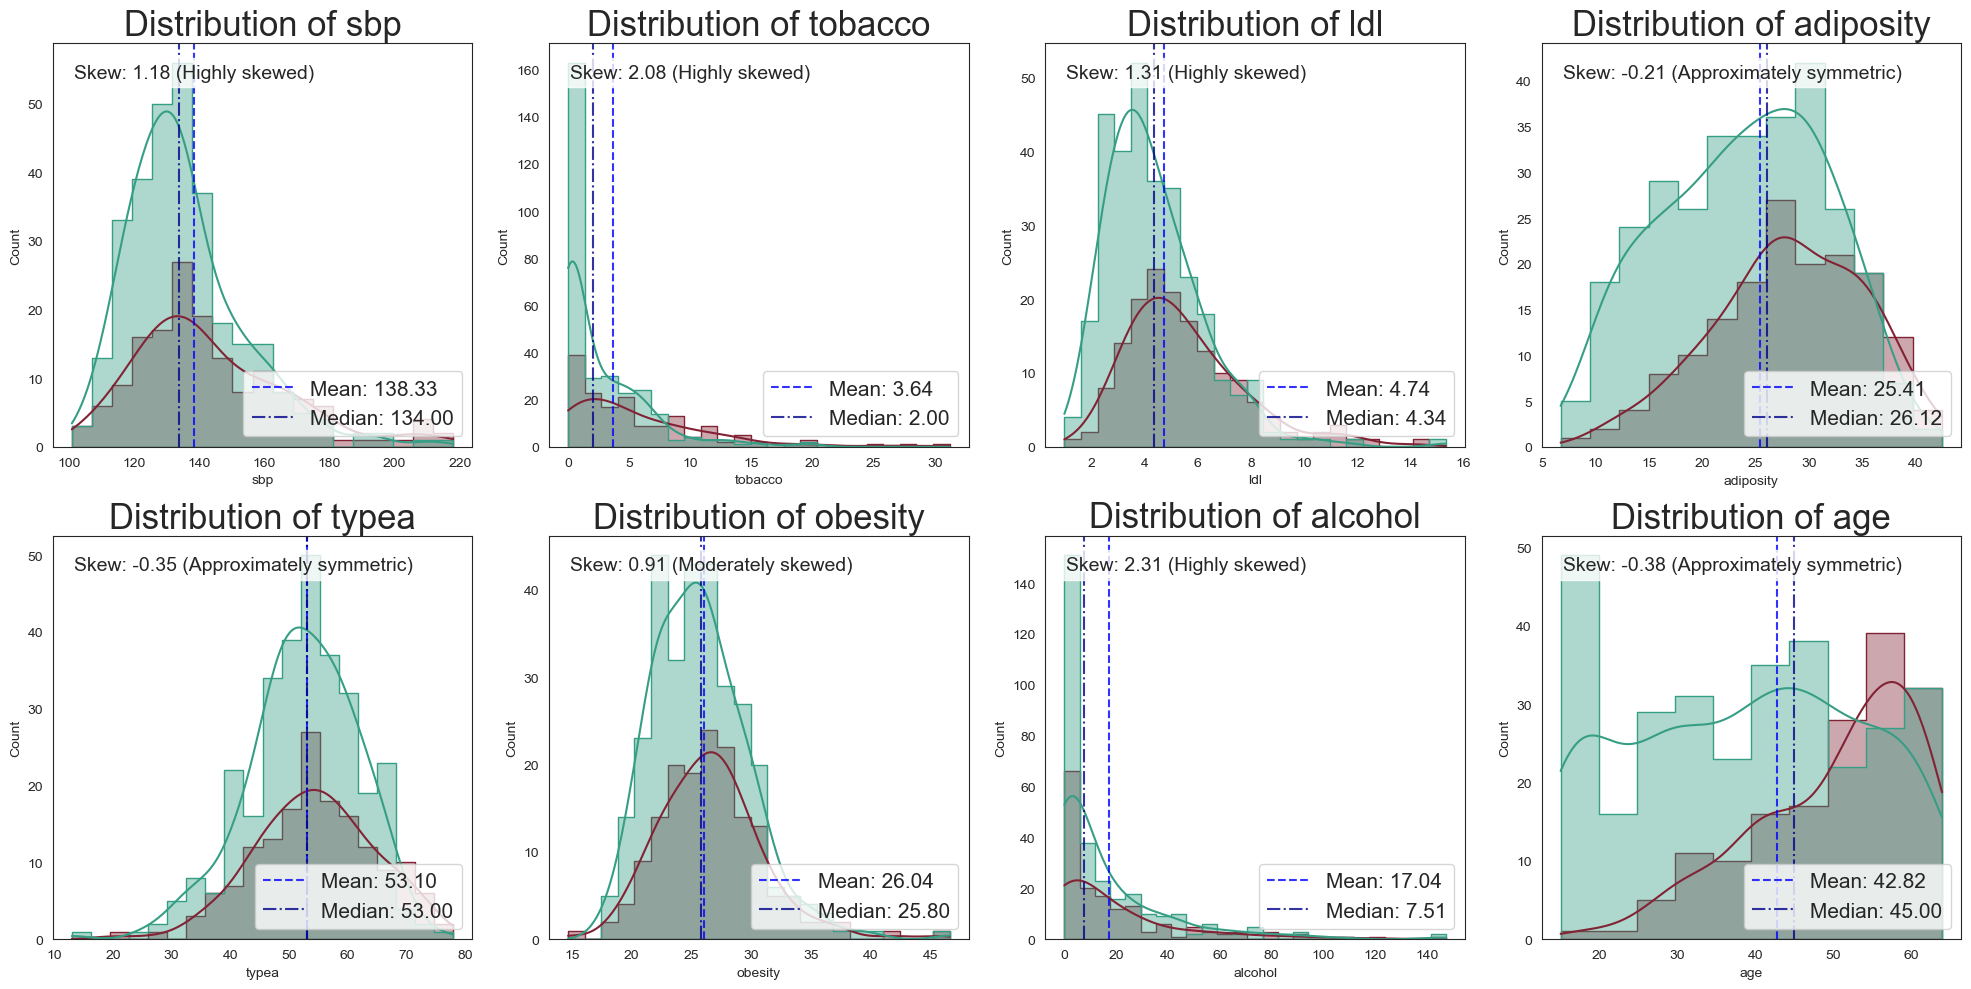

In [8]:
# Create a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # Flatten to simplify iteration

# Process each feature on its corresponding axis
for ax, feature in zip(axes, numerical_features):
    # Histogram with KDE on the given axis
    sns.histplot(data=heart_disease_data, x=feature, kde=True, hue='chd', 
                 palette=['#369E84', '#822335'], alpha=0.4, element="step", ax=ax)
    
    # Calculate statistics
    mean = heart_disease_data[feature].mean()
    median = heart_disease_data[feature].median()
    skew = heart_disease_data[feature].skew()
    
    # Add vertical lines for mean and median
    ax.axvline(mean, color='blue', linestyle='--', alpha=0.8, label=f'Mean: {mean:.2f}')
    ax.axvline(median, color='darkblue', linestyle='-.', alpha=0.8, label=f'Median: {median:.2f}')
    
    # Create skewness annotation
    skew_text = f'Skew: {skew:.2f}'
    if abs(skew) > 1:
        skew_text += ' (Highly skewed)'
    elif abs(skew) > 0.5:
        skew_text += ' (Moderately skewed)'
    else:
        skew_text += ' (Approximately symmetric)'
    
    # Place the annotation on the current axis
    ax.text(0.05, 0.95, skew_text, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    
    # Set title and legend for the subplot
    ax.set_title(f'Distribution of {feature}', fontsize=25)
    ax.legend(fontsize=15, loc='lower right')

plt.tight_layout()
plt.savefig("plots/feature_distribution_numerical.png", dpi=300)
plt.show()


<Figure size 1000x600 with 0 Axes>

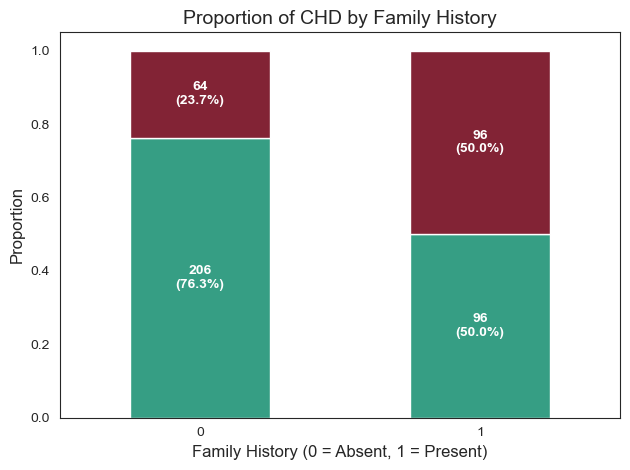

In [34]:
# Define color scheme for visualization consistency
# Green for no CHD (0), burgundy for CHD present (1)
custom_palette = {0: "#369E84", 1: "#822335"}

# Create a new figure with appropriate dimensions
plt.figure(figsize=(10, 6))

# Generate contingency table of family history vs. CHD
famhist_counts = pd.crosstab(heart_disease_data['famhist'], heart_disease_data['chd'])

# Calculate proportions within each family history category
famhist_props = famhist_counts.div(famhist_counts.sum(axis=1), axis=0)

# Create stacked bar chart with our custom color palette
famhist_props.plot(kind='bar', stacked=True, color=[custom_palette[0], custom_palette[1]])

# Add descriptive labels and title
plt.title('Proportion of CHD by Family History', fontsize=14)
plt.xlabel('Family History (0 = Absent, 1 = Present)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=0)  # Keep x-axis labels horizontal

# Remove legend as colors are self-explanatory in context
plt.legend([], [], frameon=False)

# Annotate each segment with count and percentage for better interpretation
for i, counts in enumerate(famhist_counts.values):
    total = counts.sum()
    for j, count in enumerate(counts):
        # Calculate percentage of this segment
        percentage = count / total * 100
        
        # Calculate vertical position for text (center of segment)
        y = (counts[:j].sum() + count / 2) / total
        
        # Add text annotation with count and percentage
        plt.text(i, y, f'{count}\n({percentage:.1f}%)',
                 ha='center', va='center', color='white', fontweight='bold')

# Ensure proper spacing between elements
plt.tight_layout()

# Save high-resolution image for reporting
plt.savefig("plots/feature_distribution_famhist.png", dpi=300)

# Display the plot
plt.show()


### Proof of normality

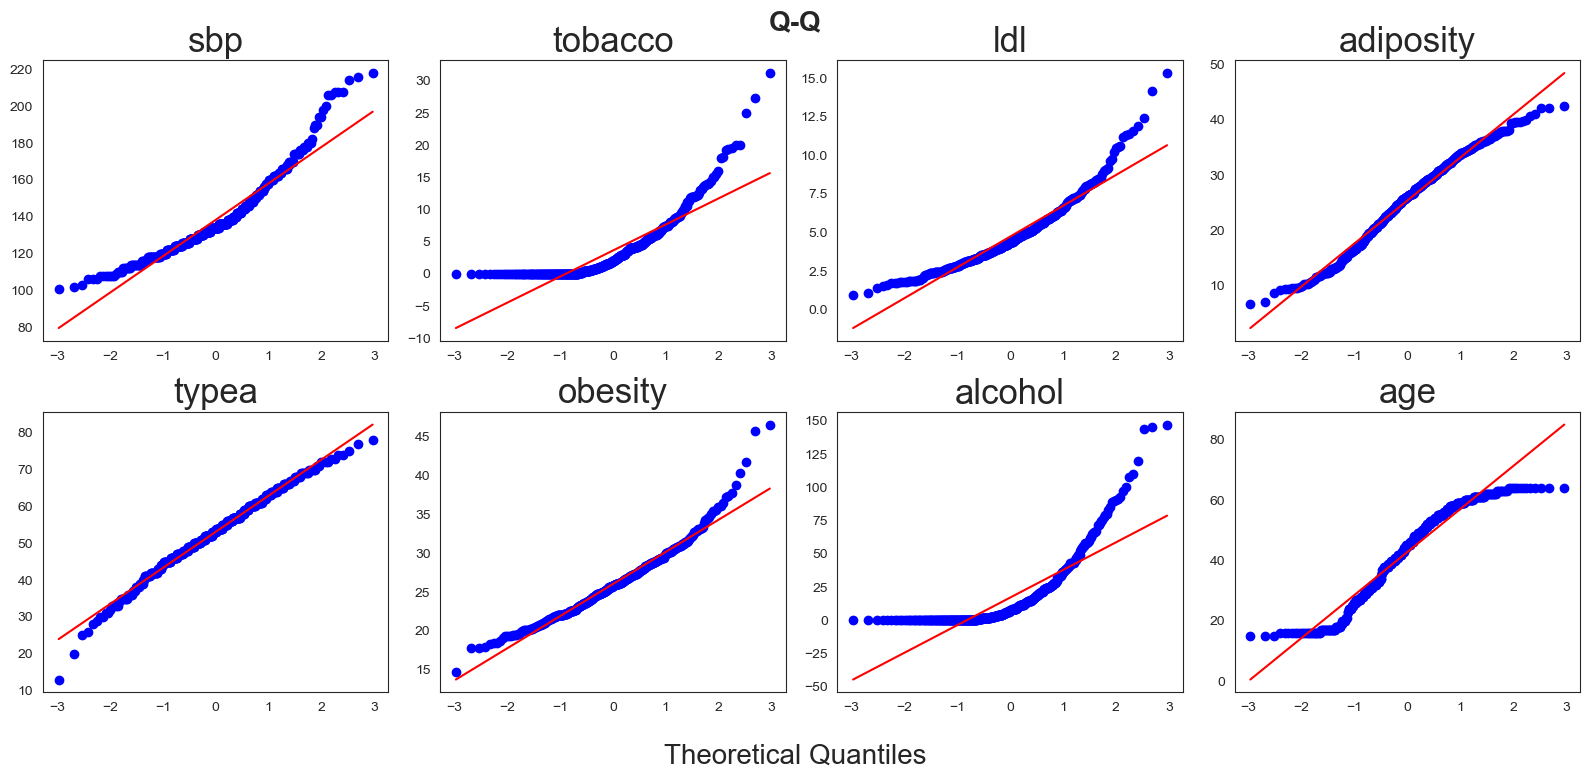

In [37]:
# Create a grid of Q-Q plots to assess normality of numerical features
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    # Generate probability plot comparing feature distribution to normal distribution
    stats.probplot(heart_disease_data[feature], plot=axes[i])
    # Add feature name as subplot title
    axes[i].set_title(feature, fontsize=25)
    # Remove redundant axis labels from individual subplots
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Add main title for the entire figure
fig.suptitle("Q-Q", fontsize=20, fontweight='bold', y=0.95)

# Add shared x-axis label for all subplots
fig.supxlabel("Theoretical Quantiles", fontsize=20, y=0)

# Optimize spacing between subplots
plt.tight_layout()
# Save high-resolution image
plt.savefig("plots/q-q.png", dpi=300)
# Display the visualization
plt.show()

### Correlation Analysis

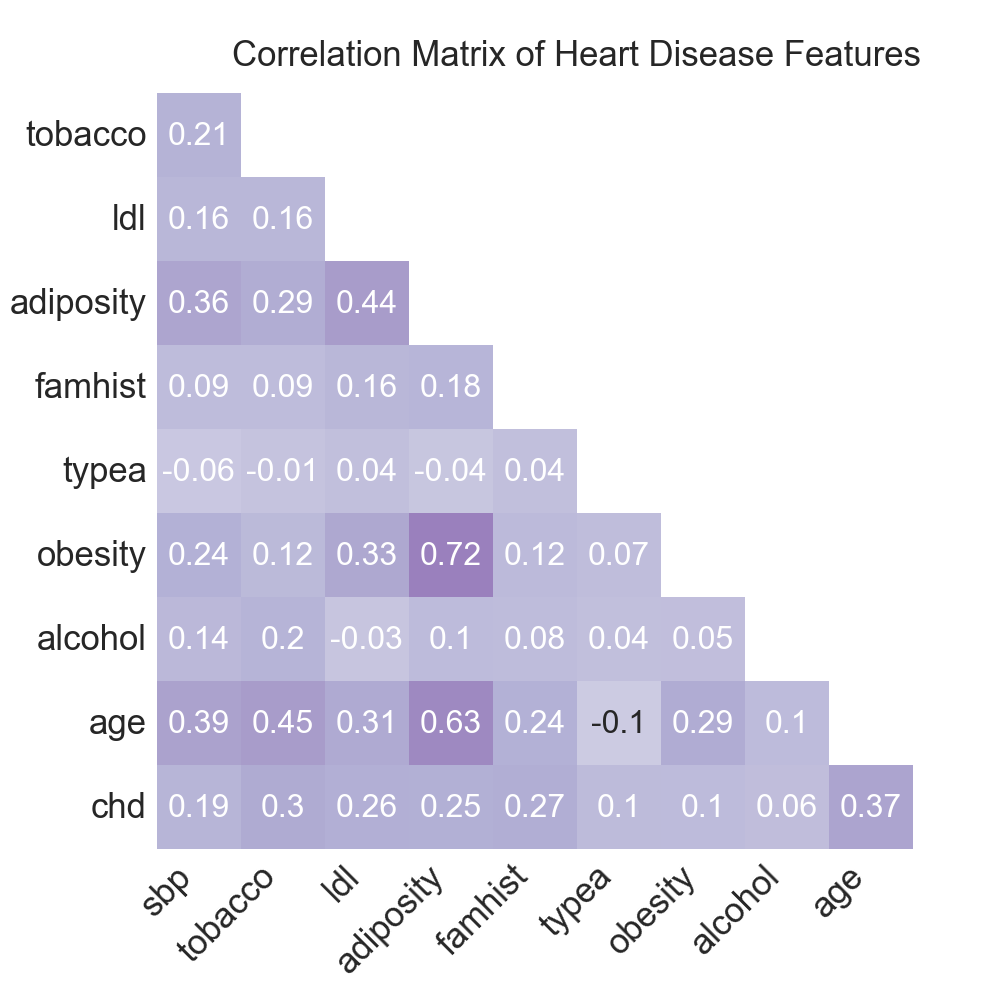

In [46]:
plt.figure(figsize=(12, 10))
correlation_matrix = heart_disease_data.corr()

# Generate a boolean mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Format correlation values to display with 2 decimal places
annot = correlation_matrix.round(2).astype(str)
# Clear diagonal values for cleaner visualization
for i in range(len(annot)):
    annot.iloc[i, i] = ""

# Visualize correlation matrix as heatmap
heatmap = sns.heatmap(
    correlation_matrix,
    annot=annot,
    fmt="",
    cmap="Purples",
    mask=mask,
    vmin=-1,
    vmax=1,
    square=True,
    cbar=False,  # Disable colorbar for cleaner appearance
    alpha=0.6,
    annot_kws={"fontsize": 23}  # Larger font for correlation values
)

plt.title('Correlation Matrix of Heart Disease Features', fontsize=25, pad=-40)  # Adjust title position

# Extract current tick labels
xlabels = [label.get_text() for label in heatmap.get_xticklabels()]
ylabels = [label.get_text() for label in heatmap.get_yticklabels()]

# Remove redundant labels at corners
ylabels[0] = ""    # Remove top-left label
xlabels[-1] = ""   # Remove bottom-right label

# Apply modified tick labels with formatting
heatmap.set_xticklabels(xlabels, rotation=45, ha='right', fontsize=25)  # Angle x-labels for readability
heatmap.set_yticklabels(ylabels, rotation=0, fontsize=25)  # Keep y-labels horizontal

plt.tight_layout()
plt.savefig("plots/correlation_matrix.png", dpi=300)
plt.show()

In [47]:
# Calculate VIF for each feature
X = heart_disease_data.drop('chd', axis=1)  # Exclude the target variable
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF results
print("Variance Inflation Factor (VIF) for each feature:")
print(vif_data)


Variance Inflation Factor (VIF) for each feature:
     Feature        VIF
0        sbp  39.559488
1    tobacco   2.100077
2        ldl   7.955978
3  adiposity  38.211907
4    famhist   1.847693
5      typea  23.987961
6    obesity  68.510957
7    alcohol   1.592733
8        age  20.375501


In [48]:

# Calculate point-biserial correlations specifically for the target variable
target_correlations = {}
features = heart_disease_data.columns.drop('chd')

for feature in features:
    correlation, pvalue = pointbiserialr(heart_disease_data[feature], heart_disease_data['chd'])
    target_correlations[feature] = {'correlation': correlation, 'p-value': round(pvalue, 5)}

# Convert to DataFrame for better visualization
target_corr_df = pd.DataFrame(target_correlations).T
target_corr_df = target_corr_df.sort_values('correlation', ascending=False)
print("Point-biserial correlations with CHD (sorted):")
print(target_corr_df)


Point-biserial correlations with CHD (sorted):
           correlation  p-value
age           0.372973  0.00000
tobacco       0.299718  0.00000
famhist       0.272373  0.00000
ldl           0.263053  0.00000
adiposity     0.254121  0.00000
sbp           0.192354  0.00003
typea         0.103156  0.02661
obesity       0.100095  0.03147
alcohol       0.062531  0.17969


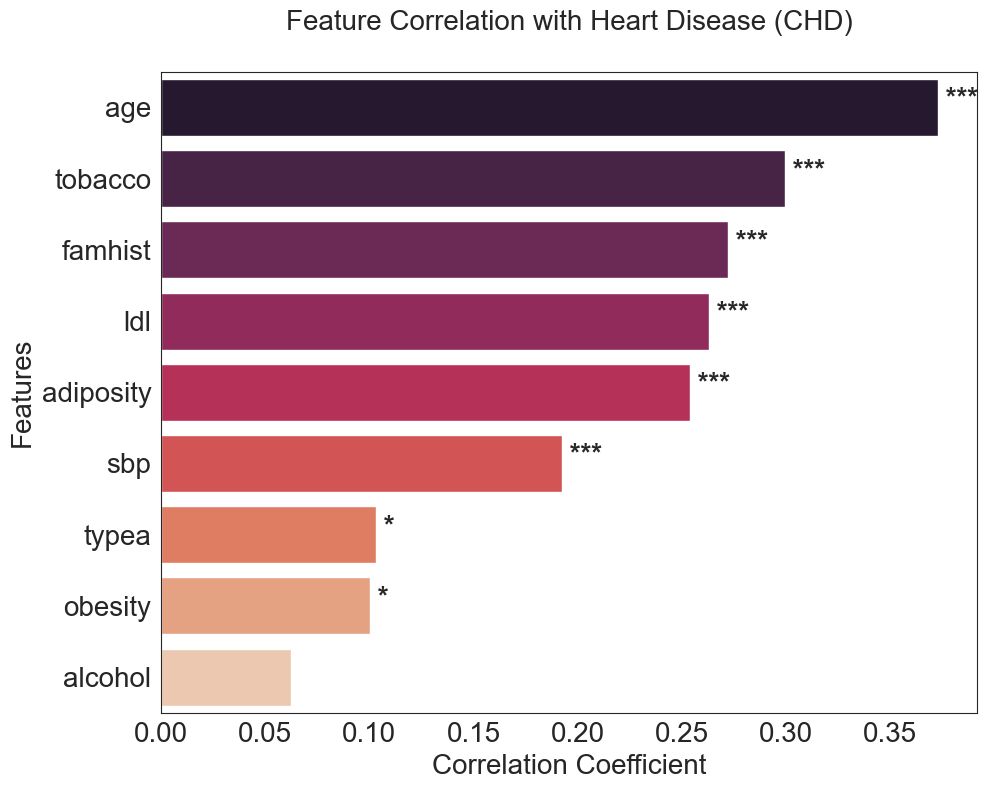

In [49]:
# Create a bar plot visualizing the correlation between each feature and CHD
plt.figure(figsize=(10, 8))
bars = sns.barplot(
    x=target_corr_df['correlation'], 
    y=target_corr_df.index,
    hue=target_corr_df.index,  # Use feature names for color coding
    legend=False,              # Remove redundant legend
    palette='rocket'           # Use rocket color palette for visual appeal
)
# Set plot title with padding for better spacing
plt.title('Feature Correlation with Heart Disease (CHD)', fontsize=20, pad=30)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)  # Add reference line at zero
plt.xlabel('Correlation Coefficient', fontsize=20)  # Label x-axis
plt.ylabel('Features', fontsize=20)  # Label y-axis

# Enhance readability with larger font sizes
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Mark statistical significance levels with asterisks
for i, p in enumerate(target_corr_df['p-value']):
    if p < 0.001:
        plt.text(target_corr_df['correlation'].iloc[i], i, ' ***', fontweight='bold', fontsize=20)  # p < 0.001
    elif p < 0.01:
        plt.text(target_corr_df['correlation'].iloc[i], i, ' **', fontweight='bold', fontsize=20)   # p < 0.01
    elif p < 0.05:
        plt.text(target_corr_df['correlation'].iloc[i], i, ' *', fontweight='bold', fontsize=20)    # p < 0.05
plt.tight_layout()  # Optimize plot layout
plt.savefig("plots/feature_correlation.png", dpi=300)  # Save high-resolution image
plt.show()  # Display the plot

# ML Part

In [40]:
import warnings
warnings.filterwarnings("ignore")

# -----------------------------------------------
# Data Preparation
# -----------------------------------------------
# Split the dataset into features and target variable
X = heart_disease_data.drop(columns=['chd'])
y = heart_disease_data['chd']

# Create stratified train/test split with 90/10 ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# -----------------------------------------------
# Evaluation Framework Setup
# -----------------------------------------------
# Define comprehensive scoring metrics for model evaluation
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'roc_auc': 'roc_auc',
    'f1': make_scorer(f1_score, zero_division=0),
    'sensitivity': make_scorer(recall_score, pos_label=1, zero_division=0),  # True Positive Rate
    'specificity': make_scorer(recall_score, pos_label=0, zero_division=0)   # True Negative Rate
}

# Configure stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# -----------------------------------------------
# Model Pipeline Definitions
# -----------------------------------------------
pipelines = {}

# Logistic Regression: Using PCA to handle multicollinearity
pipelines['LogisticRegression'] = {
    "pipeline": Pipeline([
         ('scaler', StandardScaler()),
         ('pca', PCA(random_state=42)),
         ('clf', LogisticRegression(penalty='l2', random_state=42))
    ]),
    "param_grid": {
         'pca__n_components': [0.5, 0.7, 0.9],  # Variance retention percentages
         'clf__C': [0.01, 0.1, 1, 10, 100],     # Regularization strength
         'clf__solver': ['liblinear', 'newton-cholesky']
    }
}

# Random Forest: No preprocessing needed as trees handle various data types well
pipelines['RandomForest'] = {
    "pipeline": Pipeline([
         ('clf', RandomForestClassifier(random_state=42))
    ]),
    "param_grid": {
         'clf__n_estimators': [100, 200, 300],
         'clf__max_depth': [None, 5, 10, 15],
         'clf__min_samples_split': [2, 5, 10]
    }
}

# Gradient Boosting: Tree-based model requiring no preprocessing
pipelines['GBM'] = {
    "pipeline": Pipeline([
         ('clf', GradientBoostingClassifier(random_state=42))
    ]),
    "param_grid": {
         'clf__n_estimators': [100, 200, 300],
         'clf__learning_rate': [0.01, 0.1, 0.2],
         'clf__max_depth': [3, 5, 7]
    }
}

# Support Vector Machine: Scaling + SMOTE for imbalanced data
pipelines['SVM'] = {
    "pipeline": ImbPipeline([
         ('scaler', StandardScaler()),
         ('smote', SMOTE(random_state=42)),
         ('clf', SVC(random_state=42, probability=True))
    ]),
    "param_grid": {
         'clf__C': [0.1, 1, 10, 100],
         'clf__gamma': ['scale', 'auto', 0.1, 0.01],
         'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
         'clf__degree': [2, 3],  # For polynomial kernel
         'clf__coef0': [0.0, 0.5, 1.0],  # For polynomial and sigmoid kernels
         'smote__k_neighbors': [3, 5, 7]
    }
}

# Naive Bayes: Log transform for normality + scaling + SMOTE
pipelines['NaiveBayes'] = {
    "pipeline": ImbPipeline([
         ('log', FunctionTransformer(np.log1p, validate=False)),
         ('scaler', StandardScaler()),
         ('smote', SMOTE(random_state=42)),
         ('clf', GaussianNB())
    ]),
    "param_grid": {
         'clf__var_smoothing': [1e-09, 1e-08, 1e-07],
         'smote__k_neighbors': [3, 5, 7]
    }
}

# Linear Discriminant Analysis: Log transform + scaling + PCA + SMOTE
pipelines['LDA'] = {
    "pipeline": ImbPipeline([
         ('log', FunctionTransformer(np.log1p, validate=False)),
         ('scaler', StandardScaler()),
         ('pca', PCA(random_state=42)),
         ('smote', SMOTE(random_state=42)),
         ('clf', LinearDiscriminantAnalysis())
    ]),
    "param_grid": {
         'clf__solver': ['lsqr'],  # lsqr supports shrinkage parameter
         'clf__shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
         'smote__k_neighbors': [3, 5, 7],
         'pca__n_components': [0.5, 0.7, 0.9]
    }
}

# Quadratic Discriminant Analysis: Log transform + scaling + PCA + SMOTE
pipelines['QDA'] = {
    "pipeline": ImbPipeline([
         ('log', FunctionTransformer(np.log1p, validate=False)),
         ('scaler', StandardScaler()),
         ('pca', PCA(random_state=42)),
         ('smote', SMOTE(random_state=42)),
         ('clf', QuadraticDiscriminantAnalysis())
    ]),
    "param_grid": {
         'clf__reg_param': [0.0, 0.1, 0.5, 1.0],
         'smote__k_neighbors': [3, 5, 7],
         'pca__n_components': [0.5, 0.7, 0.9]
    }
}

# -----------------------------------------------
# Model Training and Evaluation
# -----------------------------------------------
results_summary = {}
best_models = {}
test_results = {}

print("Evaluating models on training set with 10-fold CV:\n")
for model_name, model_dict in pipelines.items():
    print(f"--- {model_name} ---")
    pipeline = model_dict["pipeline"]
    param_grid = model_dict["param_grid"]
    
    # Perform grid search with cross-validation
    grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scoring,
                        refit='sensitivity', n_jobs=-1, return_train_score=True, error_score='raise')
    grid.fit(X_train, y_train)
    
    # Extract best parameters and performance metrics
    best_params = grid.best_params_
    best_roc_auc = grid.best_score_
    best_index = grid.best_index_
    best_accuracy = grid.cv_results_['mean_test_accuracy'][best_index]
    best_precision = grid.cv_results_['mean_test_precision'][best_index]
    best_recall = grid.cv_results_['mean_test_recall'][best_index]
    best_f1 = grid.cv_results_['mean_test_f1'][best_index]
    best_sensitivity = grid.cv_results_['mean_test_sensitivity'][best_index]
    best_specificity = grid.cv_results_['mean_test_specificity'][best_index]
    
    # Display cross-validation results
    print("Best Parameters:", best_params)
    print(f"CV Results:")
    print(f"  Accuracy: {best_accuracy:.3f}")
    print(f"  Precision: {best_precision:.3f}")
    print(f"  Recall: {best_recall:.3f}")
    print(f"  F1 Score: {best_f1:.3f}")
    print(f"  Sensitivity: {best_sensitivity:.3f}")
    print(f"  Specificity: {best_specificity:.3f}")
    print(f"  ROC AUC: {best_roc_auc:.3f}\n")
    
    # Store cross-validation results
    results_summary[model_name] = {
        "best_params": best_params,
        "roc_auc": best_roc_auc,
        "accuracy": best_accuracy,
        "precision": best_precision,
        "recall": best_recall,
        "f1": best_f1,
        "sensitivity": best_sensitivity,
        "specificity": best_specificity
    }
    best_models[model_name] = grid.best_estimator_
    
    # Evaluate on test set
    y_pred = grid.best_estimator_.predict(X_test)
    if hasattr(grid.best_estimator_, "predict_proba"):
        y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
        test_roc_auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        test_roc_auc = None
    
    # Calculate test set performance metrics    
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred, zero_division=0)
    test_recall = recall_score(y_test, y_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_pred, zero_division=0)
    test_sensitivity = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    test_specificity = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
    
    # Store test results
    test_results[model_name] = {
        "accuracy": test_accuracy,
        "precision": test_precision,
        "recall": test_recall,
        "roc_auc": test_roc_auc,
        "f1": test_f1,
        "sensitivity": test_sensitivity,
        "specificity": test_specificity
    }
    
    # Display test set results
    print("Test Set Results:")
    print(f"  Accuracy: {test_accuracy:.3f}")
    print(f"  Precision: {test_precision:.3f}")
    print(f"  Recall: {test_recall:.3f}")
    print(f"  F1 Score: {test_f1:.3f}")
    print(f"  Sensitivity: {test_sensitivity:.3f}")
    print(f"  Specificity: {test_specificity:.3f}")
    if test_roc_auc is not None:
        print(f"  ROC AUC: {test_roc_auc:.3f}")
    else:
        print("  ROC AUC: N/A")
    print()

# -----------------------------------------------
# Model Comparison and Selection
# -----------------------------------------------
# Find best model based on sensitivity (our primary metric)
best_test_model_name = max(
    [name for name in test_results.keys() if test_results[name]["sensitivity"] is not None],
    key=lambda k: test_results[k]["sensitivity"]
)

# Display summary of best models
print("\n*** Best Model Summary ***")
print(f"Best Model (by CV Sensitivity): {max(results_summary, key=lambda k: results_summary[k]['sensitivity'])}")
print(f"Best Model (by Test Sensitivity): {best_test_model_name}\n")

# Create comparison table of all models
print("---------------------------------- Test Set Performance Comparison ---------------------------------")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10} {'ROC AUC':<10} {'Sensitivity':<10} {'Specificity':<10}")
print("-" * 100)
for model_name in test_results:
    acc = f"{test_results[model_name]['accuracy']:.3f}"
    prec = f"{test_results[model_name]['precision']:.3f}"
    rec = f"{test_results[model_name]['recall']:.3f}"
    f1 = f"{test_results[model_name]['f1']:.3f}"
    roc = f"{test_results[model_name]['roc_auc']:.3f}" if test_results[model_name]['roc_auc'] is not None else "N/A"
    sens = f"{test_results[model_name]['sensitivity']:.3f}"
    spec = f"{test_results[model_name]['specificity']:.3f}"
    print(f"{model_name:<20} {acc:<10} {prec:<10} {rec:<10} {f1:<10} {roc:<10} {sens:<10} {spec:<10}")


Evaluating models on training set with 10-fold CV:

--- LogisticRegression ---
Best Parameters: {'clf__C': 0.01, 'clf__solver': 'liblinear', 'pca__n_components': 0.9}
CV Results:
  Accuracy: 0.720
  Precision: 0.612
  Recall: 0.575
  F1 Score: 0.582
  Sensitivity: 0.575
  Specificity: 0.797
  ROC AUC: 0.575

Test Set Results:
  Accuracy: 0.766
  Precision: 0.647
  Recall: 0.688
  F1 Score: 0.667
  Sensitivity: 0.688
  Specificity: 0.806
  ROC AUC: 0.843

--- RandomForest ---
Best Parameters: {'clf__max_depth': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 300}
CV Results:
  Accuracy: 0.716
  Precision: 0.612
  Recall: 0.471
  F1 Score: 0.521
  Sensitivity: 0.471
  Specificity: 0.845
  ROC AUC: 0.471

Test Set Results:
  Accuracy: 0.638
  Precision: 0.455
  Recall: 0.312
  F1 Score: 0.370
  Sensitivity: 0.312
  Specificity: 0.806
  ROC AUC: 0.712

--- GBM ---
Best Parameters: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 300}
CV Results:
  Accuracy: 0.68

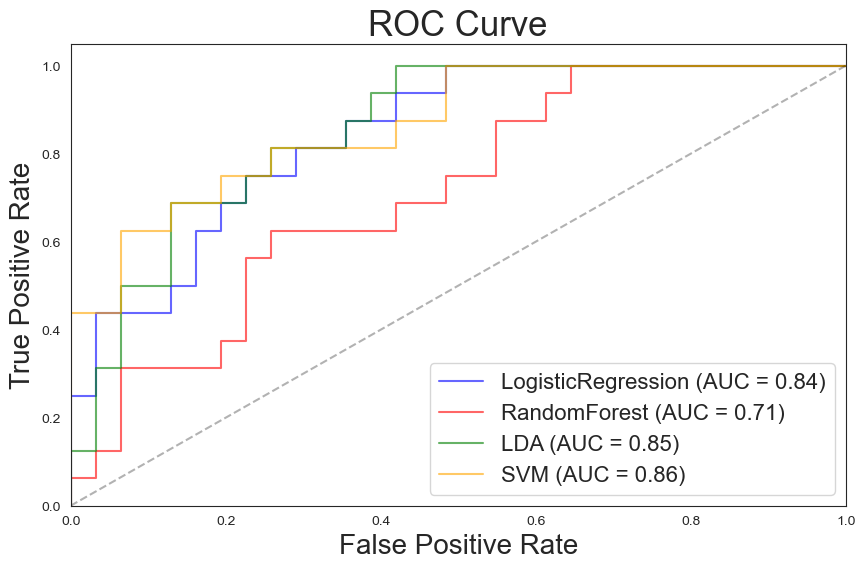

In [41]:
# -----------------------------------------------
# Visualizing Model Performance with ROC Curves
# -----------------------------------------------
# Create a plot to compare the ROC curves of our best performing models
# This helps us visualize the trade-off between sensitivity and specificity

plt.figure(figsize=(10, 6))
# Start with Logistic Regression (shown in blue)
if 'LogisticRegression' in best_models:
    y_proba = best_models['LogisticRegression'].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label='LogisticRegression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)), color='blue', alpha=0.6)

# Add ROC curves for other key models with distinct colors for visual clarity
colors = ['red', 'green', 'orange']
for model_name, color in zip(['RandomForest', 'LDA', 'SVM'], colors):
    if model_name in best_models:
        y_proba = best_models[model_name].predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_proba):.2f})', color=color, alpha=0.6)

# Add diagonal reference line representing random chance (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve', fontsize=25)
plt.legend(loc='lower right', fontsize=16)
plt.savefig('plots/roc_curve.png', dpi=300)
plt.show()
